In [2]:
import numpy as np
from PIL import Image
import os

In [85]:
path = 'stimuli/'
blue_house = Image.open(os.path.join(path,'house_blue.bmp'))
blue_house_rgba = blue_house.convert('RGBA')
red_face = Image.open(os.path.join(path,'face_red.bmp'))
red_face_rgba = red_face.convert('RGBA')

red_house = Image.open(os.path.join(path,'house_red.bmp'))
red_house_rgba = red_house.convert('RGBA')
blue_face = Image.open(os.path.join(path,'face_blue.bmp'))
blue_face_rgba = blue_face.convert('RGBA')

In [4]:
np.arange(1,12)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [72]:
def alpha_composite_transitions(src, dst, transition_values):
    
    src = np.asarray(src)
    src1 = src.copy()
    dst = np.asarray(dst)
    dst1 = dst.copy()

    out = np.empty(src.shape, dtype = 'float')
    alpha = np.index_exp[:, :, 3:]
    src1[alpha] = transition_values[0]
    dst1[alpha] = transition_values[1]
    rgb = np.index_exp[:, :, :3]
    src_a = src1[alpha]/255.0
    dst_a = dst1[alpha]/255.0
    out[alpha] = src_a+dst_a*(1-src_a)

    old_setting = np.seterr(invalid = 'ignore')
    out[rgb] = (src[rgb]*src_a + dst[rgb]*dst_a*(1-src_a))/out[alpha]
    np.seterr(**old_setting)    
    out[alpha] *= 255
    np.clip(out,0,255)
    out = out.astype('uint8')
    out = Image.fromarray(out, 'RGBA')
    return out

In [68]:
transition_forwards = np.arange(1,255+1)
transition_backwards = np.arange(255,0,-1)
transition = list(zip(transition_forwards, transition_backwards))

In [86]:
fading_images = []
# create many transition images to have it as smooth as possible
for i, alpha_values in enumerate(transition):
    out_image_hb2fr = alpha_composite_transitions(red_face_rgba, blue_house_rgba, alpha_values)
    out_image_hb2fr.save(f'stimuli/fading/fading_hb2fr_{i}.bmp')
    out_image_hr2fb = alpha_composite_transitions(red_house_rgba, blue_face_rgba, alpha_values)
    out_image_hr2fb.save(f'stimuli/fading/fading_hr2fb_{i}.bmp')
    

In [4]:
# the fading function 
def alpha_composite(src, dst):
    '''
    Return the alpha composite of src and dst.

    Parameters:
    src -- PIL RGBA Image object
    dst -- PIL RGBA Image object

    The algorithm comes from http://en.wikipedia.org/wiki/Alpha_compositing
    '''
    # http://stackoverflow.com/a/3375291/190597
    # http://stackoverflow.com/a/9166671/190597
    src = np.asarray(src)
    dst = np.asarray(dst)
    out = np.empty(src.shape, dtype = 'float')
    alpha = np.index_exp[:, :, 3:]
    rgb = np.index_exp[:, :, :3]
    src_a = src[alpha]/255.0
    dst_a = dst[alpha]/255.0
    out[alpha] = src_a+dst_a*(1-src_a)
    old_setting = np.seterr(invalid = 'ignore')
    out[rgb] = (src[rgb]*src_a + dst[rgb]*dst_a*(1-src_a))/out[alpha]
    np.seterr(**old_setting)    
    out[alpha] *= 255
    np.clip(out,0,255)
    # astype('uint8') maps np.nan (and np.inf) to 0
    out = out.astype('uint8')
    out = Image.fromarray(out, 'RGBA')
    return out

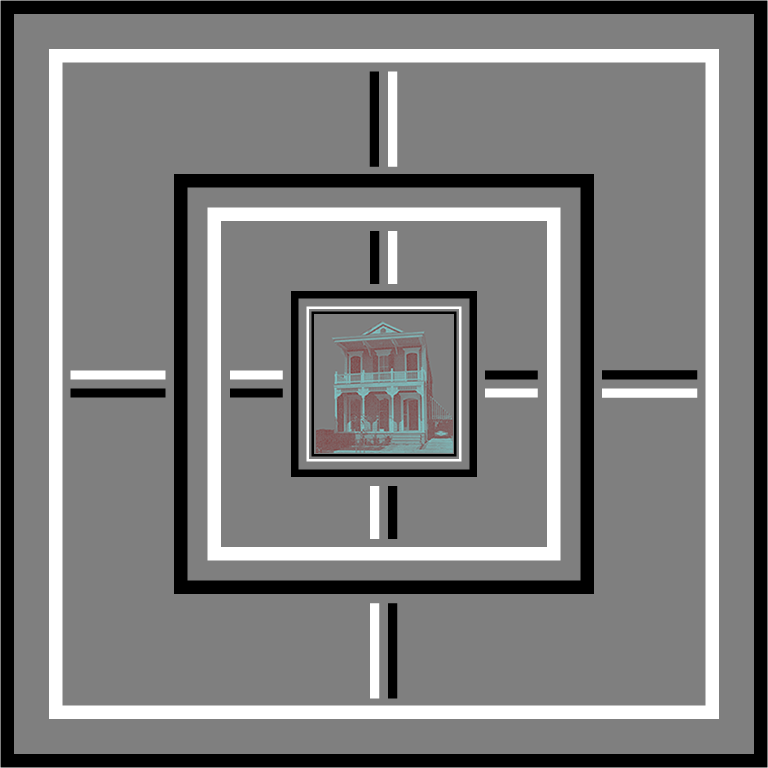

In [130]:
alpha_composite(blue_house_rgba, red_face_rgba)

#### Fading attempt (too chunky!)

In [124]:
# TODO: choose direction from where the image should be faded
# set the frame in which the fading should happen (only where the image is, so 316:452)
vertical_span = [316, 452]
horizontal_span = [316, 452]

# set the width of the wave that travels over the image
wave_span = 20 
# for every row in this wave we have to define how many pixels are beeing replaced
replace_steps = np.concatenate((np.arange(wave_span/2, 0, -1), np.arange(1, (wave_span/2)+1, 1)))


# the index where the wave currently is (start of the wave)
idx = 50

# compute the picture (the new picture will include a fading from picture1 into picture2)
picture1 = blue_house_array[vertical_span[0]:vertical_span[1],horizontal_span[0]:horizontal_span[1]]
picture2 = red_face_array[vertical_span[0]:vertical_span[1],horizontal_span[0]:horizontal_span[1]]
new_picture = picture1.copy()

for i, row in enumerate(new_picture):
    # before the wave, every pixel has to be replaced (since the wave was already there before)
    if i < idx-wave_span/2:
        for j, _ in enumerate(row):
            row[j] = picture2[i][j]
        
    # in the wave we only substitute part of the image    
    elif i >= idx-wave_span/2 and i < idx+wave_span/2:
        # what is the replacement density in this row?
        replace_step = replace_steps[i%(idx-int(wave_span/2))]

        # replace the values from picture1 with picture2 on the specified indices
        replace_indices = np.arange(0, row.shape[0], replace_step, dtype=np.int64)
        #print(replace_indices)
        #print(row.shape)
        row[replace_indices] = picture2[i][replace_indices]
        
# the image has to be put back into the frame
fadeing_image = red_face_array.copy()
fadeing_image[vertical_span[0]:vertical_span[1],horizontal_span[0]:horizontal_span[1]] = new_picture

In [120]:
im2 = Image.fromarray(new_picture)
im2.show()

In [ ]:
# a method to make the wave more irregular is to choose the replacements randomly and not every such and such step 